In [1]:
# data
import os
from glob import glob
import numpy as np
import pandas as pd

# visual
import matplotlib.pyplot as plt
import seaborn as sns

# metrics
from sklearn.metrics import classification_report, confusion_matrix

print('All packages imported!')

All packages imported!


## Task 1

In [2]:
def load_task_df(task_number):
    if task_number not in range(1, 5):
        raise ValueError("Invalid task number. Please provide a task number between 1 and 4.")

    task_fps = glob(f'ckpt/test/task_{task_number}_*/result.csv')
    dfs = []

    for fp in task_fps:
        subject = fp.split('/')[-2].split('_')[-1]
        df = pd.read_csv(fp)
        df['subject'] = subject
        dfs.append(df)

    return pd.concat(dfs, ignore_index=True)


def loo_accuracy(df):
    acc_df = df.groupby(['subject'])[['pred', 'true']].apply(lambda x: (x['pred'] == x['true']).mean()).reset_index()
    acc_df.columns = ['subject', 'accuracy']
    return acc_df


def filter_outliers(df, acc_df):
    Q1 = acc_df['accuracy'].quantile(0.25)
    Q3 = acc_df['accuracy'].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR

    filtered_subjects = acc_df[(acc_df['accuracy'] >= lower_bound)]['subject']
    removed_subjects = acc_df[~acc_df['subject'].isin(filtered_subjects)]['subject']

    print(f"Removed subjects: {', '.join(removed_subjects)}")

    return df[df['subject'].isin(filtered_subjects)]


def plot_acc_hist(df, lower_bound=0.60):
    acc_df = df.groupby(['subject'])[['pred', 'true']].apply(lambda x: (x['pred'] == x['true']).mean()).reset_index()
    acc_df.columns = ['subject', 'accuracy']

    fig, ax = plt.subplots(figsize=(10, 5))

    bins = np.arange(lower_bound, 1.05, 0.025)
    n, bins, patches = ax.hist(acc_df['accuracy'], bins=bins, color='skyblue', edgecolor='black')
    ax.set_xlim([lower_bound, 1])
    ax.set_ylim([0, max(n) + 1])

    ax.set_xlabel('LOO Accuracy')
    ax.set_ylabel('Frequency')

    plt.show()

### Data

In [11]:
task_1_df = load_task_df(4)
task_1_acc_df = loo_accuracy(task_1_df)
task_1_clean_df = filter_outliers(task_1_df, task_1_acc_df)

Removed subjects: 59, 62


### Results

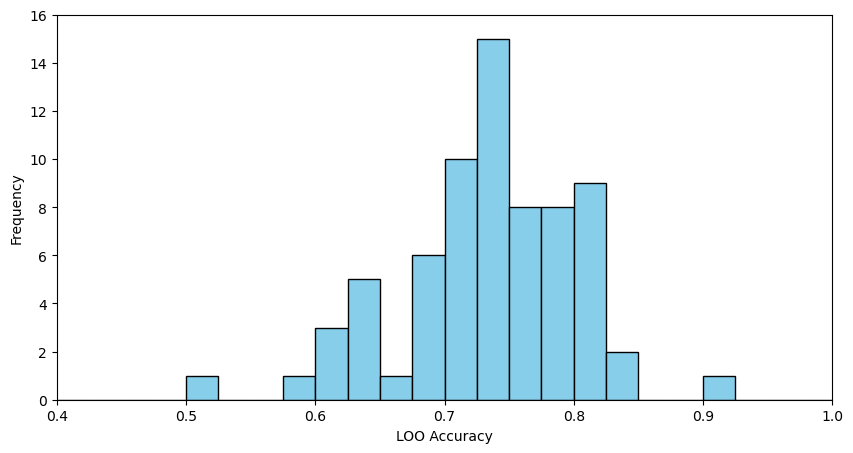

In [12]:
plot_acc_hist(task_1_df, lower_bound=0.40)